In [9]:
import json

In [15]:
b1 = open('./Examples/phenol.json').read()
print(b1)
obj = json.loads(b1)

{
  "header":{"version":"0.1"},
  "atomdefaults":{"chiral":false,"implicithcount":0,"formalcharge":0,"stereo":"Undefined"},
  "atoms":[
    {"Z":6,"impHs":1},
    {"Z":6,"impHs":1},
    {"Z":6,"impHs":1},
    {"Z":6,"impHs":1},
    {"Z":6,"impHs":1},
    {"Z":6,"impHs":0},
    {"Z":8,"impHs":1}],
  "atomproperties":[
    {"type":"partialcharges","method":"RDKit-Gasteiger",
      "values":[-0.02, -0.059, -0.062, -0.059, -0.02, 0.115, -0.508]}
],
  "bonddefaults":{"stereo":"Undefined","ringbond":false,"aromatic":false,"chiral":false,"order":1},
  "bonds":[
    {"atoms":[0,1],"order":1},
    {"atoms":[1,2],"order":2},
    {"atoms":[2,3],"order":1},
    {"atoms":[3,4],"order":2},
    {"atoms":[4,5],"order":1},
    {"atoms":[5,0],"order":2},
    {"atoms":[5,6],"order":1}
],
  "conformers":[{"dim":2,"coords":[
    [-1.2574,    1.2654],
    [-0.3882,    1.7598],
    [0.4746,    1.2542],
    [0.4682,    0.2544],
    [-0.4010,   -0.2402],
    [-1.2638,    0.2654],
    [-2.1330,   -0.2290]
    ]

In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

In [52]:
m = Chem.MolFromSmiles('c1ccccc1O')
AllChem.ComputeGasteigerCharges(m)
[float('%.3f'%float(x.GetProp("_GasteigerCharge"))) for x in m.GetAtoms()]
m.GetBondWithIdx(0).GetBondType()
a = m.GetAtomWithIdx(0)
a.GetChiralTag()

rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED

{
      "header":{"version":"0.1", "name":"example molecule"},
      "atomdefaults":{"chiral":false,"impHs":0,"chg":0,"stereo":"UNSPECIFIED","nrad":0},
      "bonddefaults":{"stereo":"UNDEF","ringbond":false,"aromatic":false,"chi":false,"order":1},
    
"atoms":[
{"Z": 6, "impHs": 1},
{"Z": 6, "impHs": 1},
{"Z": 6, "impHs": 1},
{"Z": 6, "impHs": 1},
{"Z": 6, "impHs": 1},
{"Z": 6},
{"Z": 8},
{"Z": 6, "impHs": 1},
{"Z": 6, "impHs": 1},
{"Z": 6, "impHs": 1, "stereo": "CCW"},
{"Z": 7, "impHs": 3, "chg": 1},
{"Z": 17}
],
"atomproperties":[
{"type":"partialcharges","method":"rdkit-gasteiger",
"values": [-0.019, -0.059, -0.062, -0.059, -0.019, 0.126, -0.465, 0.094, 0.024, 0.182, -0.339, -0.054]
}
],
"bonds":[
{"atoms": [0, 1], "bo": 2},
{"atoms": [1, 2], "bo": 1},
{"atoms": [2, 3], "bo": 2},
{"atoms": [3, 4], "bo": 1},
{"atoms": [4, 5], "bo": 2},
{"atoms": [5, 6], "bo": 1},
{"atoms": [6, 7], "bo": 1},
{"atoms": [7, 8], "bo": 2},
{"atoms": [8, 9], "bo": 1},
{"atoms": [9, 10], "bo": 1},
{"atoms

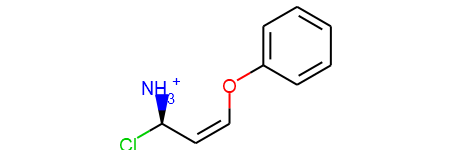

In [55]:
m = Chem.MolFromSmiles('c1ccccc1O/C=C\\[C@H]([NH3+])Cl')

def moltojson(m):
    AllChem.Compute2DCoords(m)
    AllChem.ComputeGasteigerCharges(m)
    Chem.Kekulize(m)
    from io import StringIO
    sio = StringIO()
    print("""{
      "header":{"version":"0.1", "name":"example molecule"},
      "atomdefaults":{"chiral":false,"impHs":0,"chg":0,"stereo":"UNSPECIFIED","nrad":0},
      "bonddefaults":{"stereo":"UNDEF","ringbond":false,"aromatic":false,"chi":false,"order":1},
    """,file=sio)
    print('"atoms":[',file=sio)
    for i,at in enumerate(m.GetAtoms()):
        obj = {"Z":at.GetAtomicNum()}
        if at.GetTotalNumHs():
            obj["impHs"]=at.GetTotalNumHs()
        if at.GetChiralTag() != Chem.ChiralType.CHI_UNSPECIFIED:
            chi = {Chem.ChiralType.CHI_TETRAHEDRAL_CW:"CW",Chem.ChiralType.CHI_TETRAHEDRAL_CCW:"CCW",Chem.ChiralType.CHI_OTHER:"Other"}[at.GetChiralTag()]
            obj['stereo']=chi
        if at.GetFormalCharge():
            obj['chg'] = at.GetFormalCharge()
        if at.GetNumRadicalElectrons():
            obj['nrad'] = at.GetNumRadicalElectrons()
        txt = json.dumps(obj)
        if i!=m.GetNumAtoms()-1:
            txt += ','
        print(txt,file=sio)
    print('],',file=sio)

    print('"atomproperties":[',file=sio)
    print('{"type":"partialcharges","method":"rdkit-gasteiger",',file=sio)
    print('"values":',[float('%.3f'%float(x.GetProp("_GasteigerCharge"))) for x in m.GetAtoms()],file=sio)
    print('}',file=sio)
    print('],',file=sio)

    print('"bonds":[',file=sio)
    for i,bnd in enumerate(m.GetBonds()):
        bo = {Chem.BondType.SINGLE:1,Chem.BondType.DOUBLE:2,Chem.BondType.TRIPLE:3}[bnd.GetBondType()]
        obj = {"atoms":[bnd.GetBeginAtomIdx(),bnd.GetEndAtomIdx()],"bo":bo}
        txt = json.dumps(obj)
        if(i != m.GetNumBonds()-1):
            txt += ','
        print(txt,file=sio)
    print('],',file=sio)

    print('"conformers":[{"dim":2,"coords":[',file=sio)
    for i in range(m.GetNumAtoms()):
        pos = m.GetConformer().GetAtomPosition(i)
        txt = '[%.4f, %.4f]'%(pos.x,pos.y)
        if(i!=m.GetNumAtoms()-1):
            txt += ','
        print(txt,file=sio)
    print("]}],",file=sio)


    print("""
      "representations":[{
          "toolkit":"RDKit","toolkit_version":"2018.03.1.dev1",
          "format_version":1,""",file=sio)
    print('"aromatic_atoms": %s,'%str([x.GetIdx() for x in m.GetAtoms() if x.GetIsAromatic()]),file=sio)
    print('"aromatic_bonds": %s,'%str([x.GetIdx() for x in m.GetBonds() if x.GetIsAromatic()]),file=sio)
    print(""""rings":[[0, 1, 2, 3, 4, 5]]
        }
      ]
    }""",file=sio)



    print(sio.getvalue())
    json.loads(sio.getvalue())
moltojson(m)
m